In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout, Input
from keras.layers import  Conv2D, MaxPooling2D, add
from keras import Model, utils
from tensorflow.keras.optimizers import RMSprop

import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
##################################
#   DATA GATHERING & SPLITTING   #
##################################
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))
print(total_train, ' | ', total_val, ' | ',total_test )

Streaming output truncated to the last 5000 lines.
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.695.jpg  
  inflating: cats_and_dogs/tr

In [ ]:
# Variables for pre-processing and training.
batch_size = 32
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
# 3 & 5
##########################
#   DATA PREPROCESSING   #
##########################

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'nearest', #reflect, warp
    width_shift_range = 0.1,
    height_shift_range = 0.1)

validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)


train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=True)

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)

test_data_gen = test_image_generator.flow_from_directory(
        '/content/cats_and_dogs',
        classes=['test'],
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


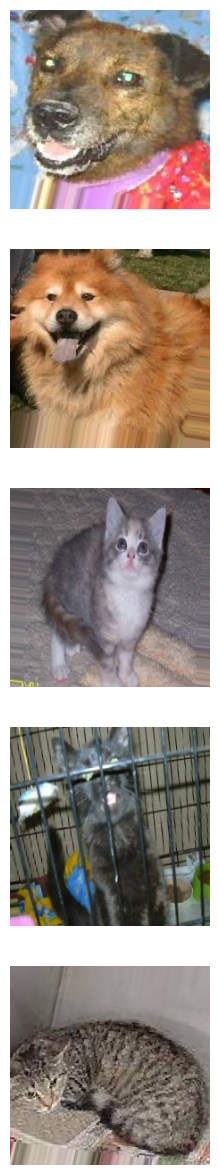

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


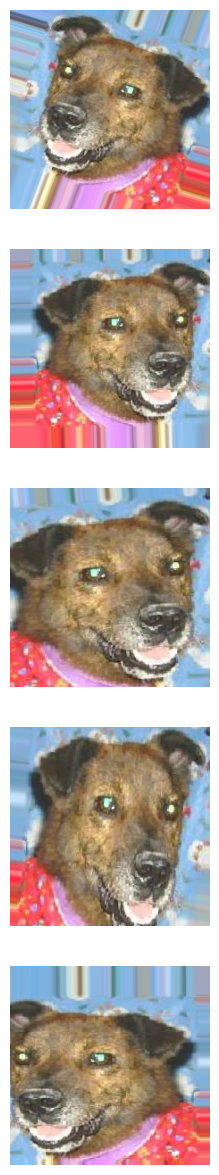

In [ ]:
# 6
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7

# COnv (16, 32, 64 [3,3]) + dense128 + batch{32} 224x224 ==>51 eStop train = 86 val = 73
# functional API ==> overfit
# COnv (32, 64, 64 [3,3]) 'elu' + dense128 + batch{32} 150x150 ==>21 eStop train = 76 val = 74
# COnv (16, 32, 64, 64, 64 [3,3]) + dense512 + batch{32} 224x224 (RMSprop) ==> estop
# COnv (16, 32, 64, 64, 64 [3,3]) 2dropout + dense512 + batch{32} 224x224 (RMSprop) ==>  0.8166 0.7933
# COnv (16, 32, 64, 64, 64 [3,3]) 2dropout + dense512 + batch{32} 224x224 (adam)  ==> 0.8298 0.80141
# COnv (32, 64, 128 [3,3]) 2dropout + dense256 + batch{32} 224x224 (adam) ==> 0.8379 0.7944
# COnv (16, 32, 64, 128 [3,3]) 2dropout + dense256 + batch{32} 224x224 (adam) perbanyak epoch ==> 0.8069, 0.79234
# COnv (16, 32, 64, 64, 64 [3,3]) 2dropout + dense256 + batch{32} 224x224 (adam) epoch 50  ==> 80 76
# COnv (16, 32, 64, 64, 64 [3,3]) 2dropout + dense256 + batch{32} 224x224 (adam) epoch 50 ilangin padding ==> 80 80

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(1,activation='sigmoid'),
  ])
model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=1)

filepath= "modelFinal.h5"
checkpoint =  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
# RMSprop(lr=0.001)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_data_gen.n//train_data_gen.batch_size
STEP_SIZE_VALID=val_data_gen.n//val_data_gen.batch_size

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [ ]:
# 8m
history = model.fit(train_data_gen,
                    validation_data = val_data_gen,
                    callbacks=[early_stoping,learning_rate_reduction, checkpoint],
                    epochs = epochs,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                   )

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.7962
Epoch 1: val_accuracy did not improve from 0.79536
62/62 [==============================] - 74s 1s/step - loss: 0.4423 - accuracy: 0.7962 - val_loss: 0.4697 - val_accuracy: 0.7843 - lr: 1.2500e-04
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8074
Epoch 2: val_accuracy improved from 0.79536 to 0.79637, saving model to modelFinal.h5
62/62 [==============================] - 74s 1s/step - loss: 0.4362 - accuracy: 0.8074 - val_loss: 0.4619 - val_accuracy: 0.7964 - lr: 1.2500e-04
Epoch 3/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8008
Epoch 3: val_accuracy did not improve from 0.79637
62/62 [==============================] - 71s 1s/step - loss: 0.4268 - accuracy: 0.8008 - val_loss: 0.4748 - val_accuracy: 0.7772 - lr: 1.2500e-04
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.7917
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 4: val_accuracy did not improve from 0.79637
62/62 [==============================] - 71s 1s/step - loss: 0.4384 - accuracy: 0.7917 - val_loss: 0.4619 - val_accuracy: 0.7933 - lr: 1.2500e-04
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8135
Epoch 5: val_accuracy did not improve from 0.79637
62/62 [==============================] - 72s 1s/step - loss: 0.4165 - accuracy: 0.8135 - val_loss: 0.4599 - val_accuracy: 0.7873 - lr: 6.2500e-05
Epoch 6/50
62/62 [==============================] - ETA: 0s - 

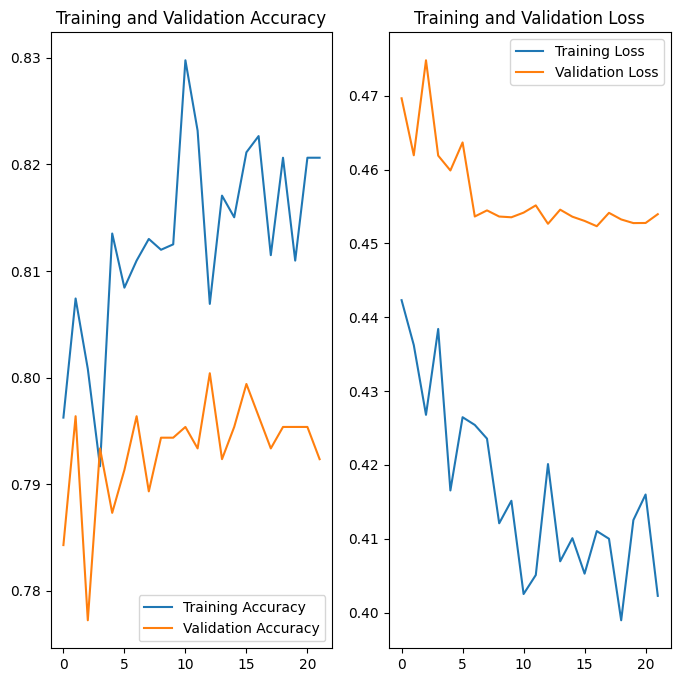

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#10
nb_samples = test_data_gen.n
probabilities = model.predict(test_data_gen, steps = 50)
print(probabilities)

 2/50 [>.............................] - ETA: 6s 

50/50 [==============================] - 0s 3ms/step
[[0.7977024 ]
 [0.26573384]
 [0.06157696]
 [0.9715907 ]
 [0.1858024 ]
 [0.22764593]
 [0.5150654 ]
 [0.16413915]
 [0.74429566]
 [0.99395   ]
 [0.06875497]
 [0.9235331 ]
 [0.07456737]
 [0.81206626]
 [0.59570926]
 [0.8810338 ]
 [0.8366508 ]
 [0.95323634]
 [0.8577719 ]
 [0.911784  ]
 [0.05105248]
 [0.16887747]
 [0.5513834 ]
 [0.61329424]
 [0.7568381 ]
 [0.08568389]
 [0.98627585]
 [0.3192408 ]
 [0.09423597]
 [0.6019494 ]
 [0.19057687]
 [0.03033911]
 [0.9613412 ]
 [0.96870387]
 [0.24436049]
 [0.39068383]
 [0.97701526]
 [0.91410494]
 [0.34409523]
 [0.20080014]
 [0.33303273]
 [0.7500291 ]
 [0.9605631 ]
 [0.84908813]
 [0.36451825]
 [0.21037537]
 [0.6636273 ]
 [0.08328116]
 [0.73021716]
 [0.17625166]]


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0
for probability, answer in zip(probabilities, answers):
  # print(round(probability.item()))
  if round(probability.item()) == answer:
    correct +=1

# for probability, answer in zip(probabilities, answers):
#   print(round(probability))
#   if round(probability) == answer:
#     correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
